# Jupyter Notebook For DTSA-5511 WK3

# Introduction

In this notebook, we tackle the challenge of identifying metastatic cancer in image patches derived from larger digital pathology scans using the PatchCamelyon (PCam) dataset. The PCam dataset requires a solution as a binary image classification task.

The goal of this competition is to develop an algorithm that accurately classifies image patches as either containing metastatic cancer or not.

In the following sections, we will outline our approach, including data preprocessing, model selection, training procedures, and evaluation metrics. By the end of this notebook, we aim to provide insights and results that contribute to the understanding of metastatic cancer detection using machine learning.


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import glob


2024-10-19 13:42:01.464166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/algorithmspath/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-10-19 13:42:01.464193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Set constants
IMG_SIZE = (128, 128)  # Image size for resizing
BATCH_SIZE = 32
EPOCHS = 10  # Adjust as needed

# Define file paths
TRAIN_LABELS_CSV = 'train_labels.csv'
TRAIN_DIR = 'train'
TEST_DIR = 'test'
SUBMISSION_CSV = 'submission.csv'

Dataset:

train_labels.csv - labels of metastatic; 220025 records

train_dir - directory of images corresponding to train_labels.csv

test_dir - directory of images to predict

In [4]:
# Load labels from CSV
train_labels = pd.read_csv(TRAIN_LABELS_CSV)
print(train_labels.head())

print(train_labels.shape)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
(220025, 2)


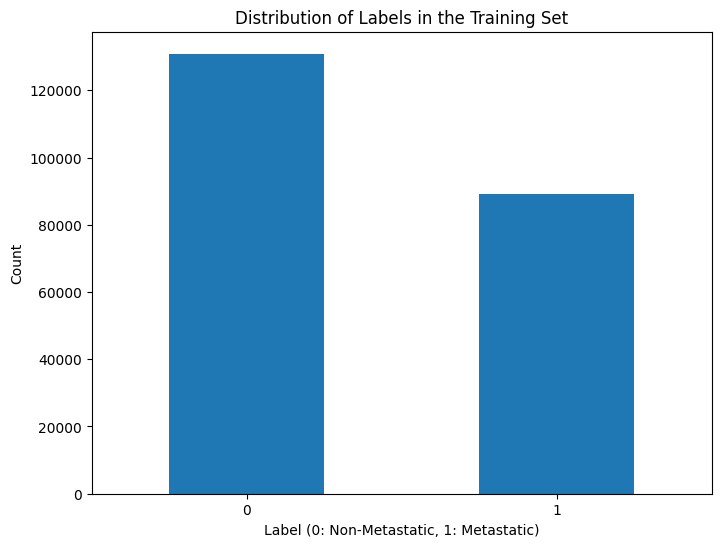

In [14]:
# Exploratory Data Analysis (EDA)
# Check the distribution of classes
label_counts = train_labels['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label (0: Non-Metastatic, 1: Metastatic)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

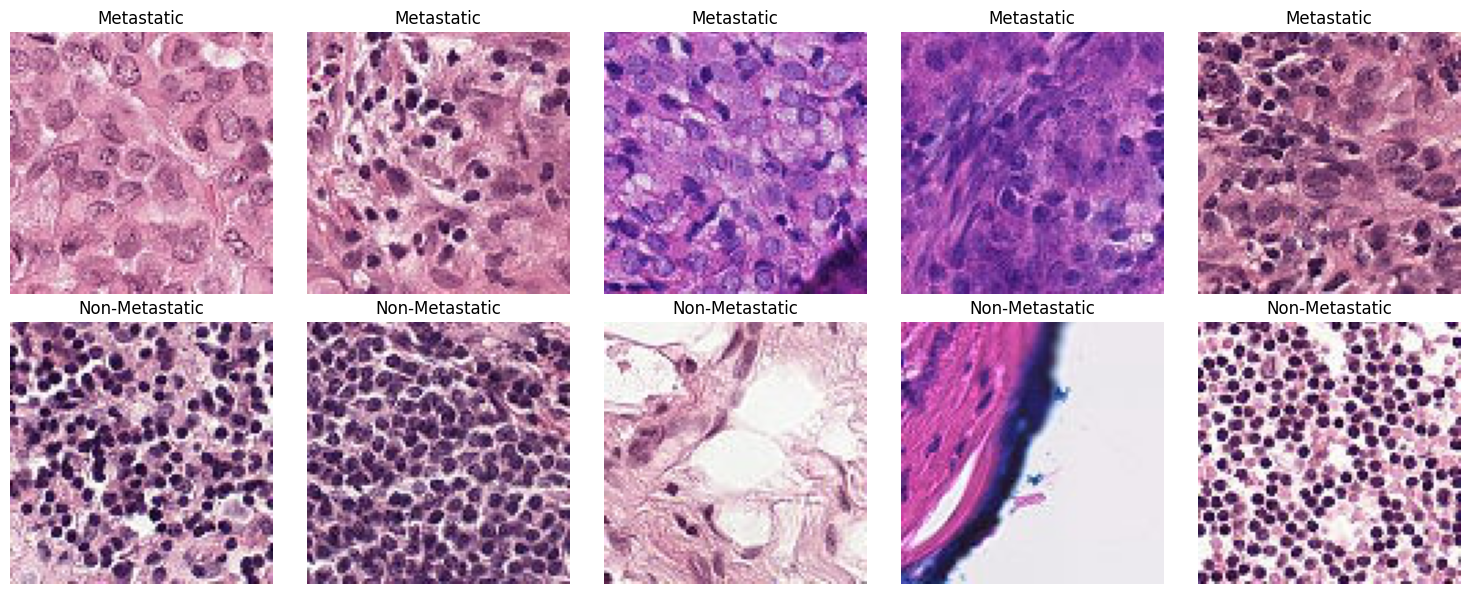

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Function to load and display images
def display_images(train_dir, labels_df, num_images=5):
    # Separate the metastatic and non-metastatic images
    metastatic_images = labels_df[labels_df['label'] == 1]['id'].values
    non_metastatic_images = labels_df[labels_df['label'] == 0]['id'].values

    # Randomly select images
    selected_metastatic = np.random.choice(metastatic_images, num_images, replace=False)
    selected_non_metastatic = np.random.choice(non_metastatic_images, num_images, replace=False)

    plt.figure(figsize=(15, 6))
    
    # Display metastatic images
    for i, img_id in enumerate(selected_metastatic):
        img_path = os.path.join(train_dir, img_id + '.tif')  # Adjust extension if necessary
        img = Image.open(img_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Metastatic')

    # Display non-metastatic images
    for i, img_id in enumerate(selected_non_metastatic):
        img_path = os.path.join(train_dir, img_id + '.tif')  # Adjust extension if necessary
        img = Image.open(img_path)
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Non-Metastatic')

    plt.tight_layout()
    plt.show()

# Display images from the dataset
# print(os.listdir(TRAIN_DIR))
display_images(TRAIN_DIR, train_labels, num_images=5)


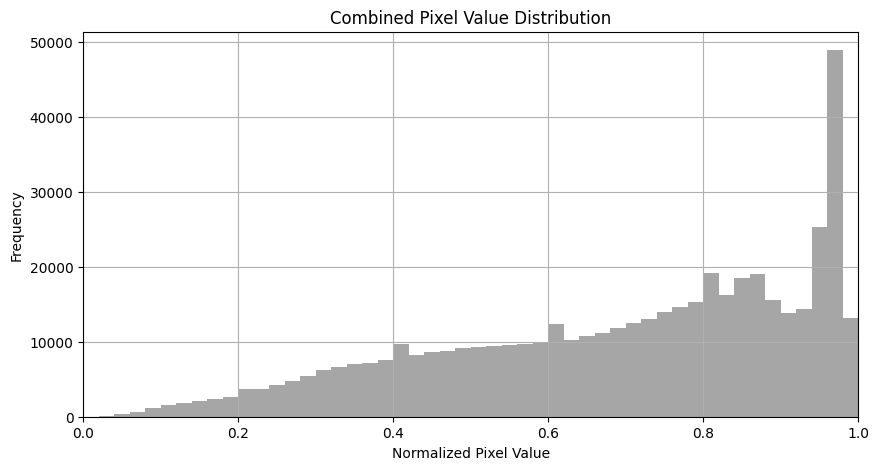

In [21]:
# Function to load and resize images
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, IMG_SIZE)  # Resize to your desired size
        img = img.astype(np.float32) / 255.0  # Scale to [0, 1]
        return img
    return None

# Load the first 10 images
def load_first_n_images(n=10):
    images = []
    for i in range(n):
        img_path = os.path.join(TRAIN_DIR, train_labels['id'].iloc[i] + '.tif')  # Adjust extension if necessary
        img = load_image(img_path)
        if img is not None:
            images.append(img)
    return np.array(images)

# Plot combined pixel value distribution
def plot_combined_pixel_distribution(images, num_bins=50):
    # Flatten the images to get all pixel values
    pixel_values = images.flatten()  # Shape: (num_images * height * width * channels,)
    
    plt.figure(figsize=(10, 5))
    plt.hist(pixel_values, bins=num_bins, color='gray', alpha=0.7)
    plt.title('Combined Pixel Value Distribution')
    plt.xlabel('Normalized Pixel Value')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)  # Adjust for normalized pixel values
    plt.grid()
    plt.show()

# Load the first 10 images and plot their combined pixel value distribution
images = load_first_n_images(10)
plot_combined_pixel_distribution(images)

In [15]:
# Load images in batches

# Load image and perform normalization
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, IMG_SIZE)
        
        # Normalize the image
        img = img.astype(np.float32) / 255.0  # Scale to [0, 1]
        img = (img - MEAN) / STD  # Normalize using mean and std
        return img
    return None

def generate_data(batch_size):
    while True:
        for start in range(0, len(train_labels), batch_size):
            end = min(start + batch_size, len(train_labels))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                img_path = os.path.join(TRAIN_DIR, train_labels['id'].iloc[i] + '.tif')
                img = load_image(img_path)
                if img is not None:
                    batch_images.append(img)
                    batch_labels.append(train_labels['label'].iloc[i])
            yield np.array(batch_images), np.array(batch_labels)

In [16]:
# Create a CNN model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# Prepare training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(train_labels['id'], train_labels['label'], test_size=0.2, random_state=42)

# Initialize the model
model = create_model()
model

In [18]:
# Train the model
# Note: Training done outside of notebook environment.
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
train_gen = generate_data(BATCH_SIZE)

model.fit(train_gen,
          steps_per_epoch=len(X_train) // BATCH_SIZE,
          validation_data=generate_data(BATCH_SIZE),
          validation_steps=len(X_val) // BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])

2024-10-09 10:49:16.155514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2024-10-09 10:49:17.353270: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 65028096 exceeds 10% of free system memory.
2024-10-09 10:49:17.709597: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30482432 exceeds 10% of free system memory.
2024-10-09 10:49:18.037437: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 23482368 exceeds 10% of free system memory.
2024-10-09 10:49:18.152410: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30482432 exceeds 10% of free system memory.
2024-10-09 10:49:18.192791: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25719552 exceeds 10% of free system memory.


  91/5500 [..............................] - ETA: 48:00 - loss: 6.9329 - accuracy: 0.6078

KeyboardInterrupt: 

In [25]:
# Model inference on test data
def predict_test_data(test_dir):
    test_files = glob.glob(os.path.join(test_dir, '*.tif'))
    
    predictions = []
    ids = []

    for img_path in test_files[:]:
        img = load_image(img_path)
        if img is not None:
            img = np.expand_dims(img, axis=0) / 255.0  # Normalize
            pred = model.predict(img)
            predictions.append(pred[0][0])
        else:
            predictions.append(None)  # Handle non-loadable images
        ids.append( os.path.basename(img_path).replace('.tif', '') )
            
    return pd.DataFrame({
        'id': ids,
        'label': [ round(x) for x in predictions ]
    })

# Predict and save to submission file
submission_df = predict_test_data(TEST_DIR)
print(len(os.listdir(TEST_DIR)))

submission_df.to_csv(SUBMISSION_CSV, index=False)
print("Submission file saved.")

57458
Submission file saved.


# Metastatic Cancer Detection Model

## Model Architecture
The model is called a Convolutional Neural Network (CNN). It has several important parts:

1. **Convolutional Layers**: There are three of these layers. They look for features in the images using filters. The first layer has 32 filters, the second has 64, and the third has 128.
2. **Max Pooling Layers**: After each convolutional layer, there is a max pooling layer. This layer makes the images smaller and helps the model work faster.
3. **Flatten Layer**: This layer takes the 2D image data and turns it into a single line of numbers. This is needed for the next layers.
4. **Dense Layer**: This layer connects all the numbers together. It has 128 units and uses a special function called ReLU to help the model learn better.
5. **Output Layer**: The final layer has one unit that tells us if there is cancer or not. It gives a score between 0 and 1. If the score is close to 1, it means cancer is present.

## Training Process
1. **Data Preparation**: We load the images in small groups so we don’t use too much memory.
2. **Training**: We teach the model using training data. It learns to recognize signs of cancer.
3. **Validation**: We check how well the model is doing with a different set of images. This helps us see if it is learning correctly.
4. **Note on Training**: Training is done on separate environment, outside of notebook.

## Inference Steps
1. **Load Test Images**: We get the images we want to test.
2. **Make Predictions**: The model looks at each test image and decides if it shows cancer or not.
3. **Save Results**: We save these predictions in a file to send out.

This model helps us find metastatic cancer in small image patches from larger scans.
The model achieves 67% accuracy on test.
